## Supervised Learning in General
* Denetimli öğrenme, etiketlenmiş verilerden veya çıktılardan elde edilen verilerden öğrenme ile ilgilidir.
* Makine öğrenimi modeli, girdi ve kategorik çıktı verilerinden (sınıflandırma problemi) öğrenmek için tasarlanmış bir sınıflandırıcıdır.
* Çıktılar gerçek değerler olduğunda buna regresör (regresyon problemi) denir.
* Yalnızca girdi verilerinden öğrenilen makine öğrenimi modellerine genellikle denetimsiz makine öğrenimi modelleri denir.

## Supervised Learning with Randomly Generated Parameters
* Rastgele başlatılan parametrelerle denetimli bir model geliştirilebilir.
* Ardından, Adam veya Stokastik Gradient Descent (SGD) gibi bir öğrenme tekniği kullanılarak, modelin çıktıları doğru bir şekilde eşlemesi için parametreler öğrenilir.



* CIFAR-10 veri seti, on sınıfta 60.000 32x32 renkli resim içerir: uçaklar, arabalar, kuşlar, kediler, geyikler, köpekler, kurbağalar, atlar, gemiler ve kamyonlar (her sınıftan 6.000 resim).

In [2]:
 import time
 import tensorflow as tf

In [3]:
(data_x_tr, data_y_tr), (data_x_te, data_y_te) = tf.keras.datasets.cifar10.load_data()

# değerleri 0 ile 1 arasında dönüştür
data_x_tr = data_x_tr / 255
data_x_te = data_x_te / 255

data_y_tr = tf.keras.utils.to_categorical(data_y_tr)
data_y_te = tf.keras.utils.to_categorical(data_y_te)

# Boyutları yazdıralım.
print('data_x_tr: {}'.format(data_x_tr.shape))
print('data_x_te: {}'.format(data_x_te.shape))
print('data_y_tr: {}'.format(data_y_tr.shape))
print('data_y_te: {}'.format(data_y_te.shape))

data_x_tr: (50000, 32, 32, 3)
data_x_te: (10000, 32, 32, 3)
data_y_tr: (50000, 10)
data_y_te: (10000, 10)


In [4]:
# Etiketlenmiş eğitim verilerini sınırlandıralım.
# %5'lik kısmı kullandığımızı varsayalım.
rate_labeled = 0.05
num_labeled = int(data_x_tr.shape[0] * rate_labeled)
print("Etiketlenmiş eğitim verisi sayısı: {}".format(num_labeled))

# eğitim verilerinin %5'ini rastgele seçelim.
index_train = tf.experimental.numpy.random.randint(0,
                                               data_x_tr.shape[0],
                                               num_labeled)
data_x_tr = data_x_tr[index_train,:,:,:]
data_y_tr = data_y_tr[index_train,:]

# Boyutları yazdıralım.
print('data_x_tr: {}'.format(data_x_tr.shape))
print('data_x_te: {}'.format(data_x_te.shape))
print('data_y_tr: {}'.format(data_y_tr.shape))
print('data_y_te: {}'.format(data_y_te.shape))

Etiketlenmiş eğitim verisi sayısı: 2500
data_x_tr: (2500, 32, 32, 3)
data_x_te: (10000, 32, 32, 3)
data_y_tr: (2500, 10)
data_y_te: (10000, 10)


In [5]:
# DenseNet121, evrişimli (convolutional), havuzlama (pooling) ve yoğun katmanları (dense layer) içeren derin bir sinir ağı kulesidir.
layerin = tf.keras.Input(shape = (data_x_tr.shape[1],
                                  data_x_tr.shape[2],
                                  data_x_tr.shape[3]))

# DenseNet121 giriş boyutu 160 x 160 x 3 olarak ayarlanmıştır ve görüntülerimiz 32 x 32 x 3'tür. Upscale, uyumluluk için 32 x 32 görüntülerimizi 160 x 160 olacak şekilde yeniden boyutlandırmaktır.
upscale = tf.keras.layers.Lambda(lambda x: tf.image.resize_with_pad(x, 160, 160, method = tf.image.ResizeMethod.BILINEAR))(layerin)

# Burada temel modelimizi oluşturmak için ImageNet ağırlıklarını kullanacağız.
model_base = tf.keras.applications.DenseNet121(include_top = False,
                                                      weights = 'imagenet',
                                                      input_shape = (160, 160, 3),
                                                      input_tensor = upscale,
                                                      pooling = 'max')

layerout = tf.keras.layers.Dense(data_y_tr.shape[-1], activation = 'softmax')

# Aşırı öğrenmeyi azaltmak için "BatchNormalization" ekliyoruz.
model = tf.keras.models.Sequential([model_base,
                                    tf.keras.layers.BatchNormalization(),
                                    layerout])
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

print('model_base:\n')
model_base.summary()

print('model:\n')
model.summary()

model_base:

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 lambda (Lambda)                (None, 160, 160, 3)  0           ['input_1[0][0]']                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 166, 166, 3)  0          ['lambda[0][0]']                 
                                                                                                  
 conv1/conv (Conv2D)            (None, 80, 80, 64)   9408        ['zero_padding2d[0][0]']         
                                                                           

## Supervised Learning with Transfer Learning and Fine-Tuning
* Halihazırda eğitilmiş bir model kullanılarak denetimli bir model geliştirilebilir.

* Temel model olarak adlandırılan önceden eğitilmiş bir model, genellikle tamamen veya kısmen ödünç alınır ve transfer öğrenme ve ince ayar teknikleri kullanılarak mevcut sorunu hızlı bir şekilde öğrenmek için değiştirilir.

* Bir temel model genellikle yüzlerce evrişimli, yinelenen veya yoğun (yani tamamen bağlı) katman içerir. Bu katmanlar, pahalı kaynaklar kullanılarak mevcut problemden farklı bir veri seti üzerinde (günlerce) eğitilmiştir. Bu tür veri kümeleri binlerce kategoriye sahip olabilir veya milyonlarca veri noktası içerebilir.

* Temel model, öğrenilen parametreler, ağırlıklar, filtreler ve tek tabanlı modelin eğitildiği aynı veri alanındaki herhangi bir sorun için özellik temsilini tanımlayabilen çekirdeklerle zenginleştirilmiştir.

* Temel modelin giriş ve çıkış katmanları, mevcut problemle uyumlu olacak şekilde sıklıkla değiştirilir. Örneğin, giriş boyutu uyumluluğu için giriş katmanına eğitilebilir olmayan alt/üst ölçekleme katmanları eklenir. Çıkış katmanı/katmanları, geçerli veri kümesinin çıktısıyla uyumlu, eğitilebilir yoğun/SoftMax katmanlarıyla değiştirilir.

* Transfer öğreniminde temel model (veya temel modelin bir kısmı) dondurulur, yani parametreleri güncellenmez. Bunun yerine, yeni eklenen çıktı katmanı, belirlenen epoch sayısı ile nispeten yüksek bir öğrenme oranı kullanılarak eğitilir.

* Temel model halihazırda verilerden zenginleştirilmiş özellik gösterimi üretmiştir; tek görev, yeni eklenen çıktı katmanını kullanarak mevcut sorunu çözmek için bu temsilden öğrenmektir.

* Temel model (veya temel modelin bir kısmı) fine tuning işleminde dondurulmaz. Parametreleri artık, özellikle mevcut veri setinde az sayıda etiketli veri varsa, aşırı öğrenmeyi önlemek için belirlenmiş epoch sayısı ile nispeten küçük bir öğrenme oranı kullanılarak güncellenebilir. İnce ayar genellikle modelin doğruluğunu önemli ölçüde artırır.



In [6]:
# Transfer learning

# Temel modeli donduralım ve yalnızca son katmanı eğitelim
model_base.trainable = False

# Modeli yeniden derlememiz gerekiyor.
model.compile(optimizer = tf.keras.optimizers.Adam(0.001), 
              loss      = 'categorical_crossentropy', 
              metrics   = ['accuracy'])

print('model_base:\n')
model_base.summary()

print('model:\n')
model.summary()

# epochs = 3
t_start = time.time()

history = model.fit(data_x_tr,
                    data_y_tr,
                    epochs = 3,
                    batch_size = 128,
                    verbose = 1,
                    shuffle = True,
                    validation_split = 0.05)
t_end = time.time()

t_transfer_learning = t_end - t_start

print('\nTransfer learning eğitim süresi: {:06.2f} sec'.format(t_transfer_learning))

model_base:

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 lambda (Lambda)                (None, 160, 160, 3)  0           ['input_1[0][0]']                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 166, 166, 3)  0          ['lambda[0][0]']                 
                                                                                                  
 conv1/conv (Conv2D)            (None, 80, 80, 64)   9408        ['zero_padding2d[0][0]']         
                                                                           

In [7]:
# Fine Tuning
model_base.trainable = True

model.compile(optimizer = tf.keras.optimizers.Adam(0.00001), 
              loss      = 'categorical_crossentropy', 
              metrics   = ['accuracy'])

print('model_base:\n')
model_base.summary()

print('model:\n')
model.summary()

# epochs = 2
t_start = time.time()

history = model.fit(data_x_tr,
                    data_y_tr,
                    epochs = 2,
                    batch_size = 128,
                    verbose = 1,
                    shuffle = True,
                    validation_split = 0.05)
t_end = time.time()

t_fine_tuning = t_end - t_start

print('\nFine-tuning eğitim süresi: {:06.2f} sec'.format(t_fine_tuning))

accuracy_te = model.evaluate(data_x_te, 
                                data_y_te, 
                                batch_size = 128)

print('\nToplam Eğitim Süresi: {:06.2f} sec'.format(t_transfer_learning + t_fine_tuning))
print('\nTesting accuracy: {:05.2f}%'.format(accuracy_te[1] * 100))

model_base:

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 lambda (Lambda)                (None, 160, 160, 3)  0           ['input_1[0][0]']                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 166, 166, 3)  0          ['lambda[0][0]']                 
                                                                                                  
 conv1/conv (Conv2D)            (None, 80, 80, 64)   9408        ['zero_padding2d[0][0]']         
                                                                           

## Self-Supervised Learning
* Elimizde yalnızca 10.000 (%0,1) manuel olarak etiketlenmiş on milyon kedi ve köpek resmimiz olsun.

* Self-Supervised Learning (SSL) hedefi (genellikle), pretext olarak isimlendirilen bir temel model geliştirmek ve aktarmak için havuzun etiketli ve etiketlenmemiş verilerini birlikte uygulamaktır. Downstream görevindeki sınırlı etiketli verileri kullanarak bu temel modelde ince ayar yapılır.

* Ancak hem etiketlenmiş hem de etiketlenmemiş verilerden pretext modeli nasıl oluşturulur? Bir pretext modeli oluşturmak için iki temel SSL tekniği mevcuttur: **karşıtlıklı öğrenme (contrastive learning) ** ve **üretken öğrenme (generative learning) **.

* **contrastive learningte**, etiketli veya etiketsiz girdi verileri, bir büyütme tekniği kullanılarak otomatik olarak artırılır.

## Contrastive Learning
* Kontrastif öğrenmede, giriş verileri, etiketli veya etiketlenmemiş olsun, bir arttırma tekniği kullanılarak otomatik olarak arttırılır.
* Görüntü alanında popüler bir dizi arttırma teknikleri bu şekilde gösterilmiştir:
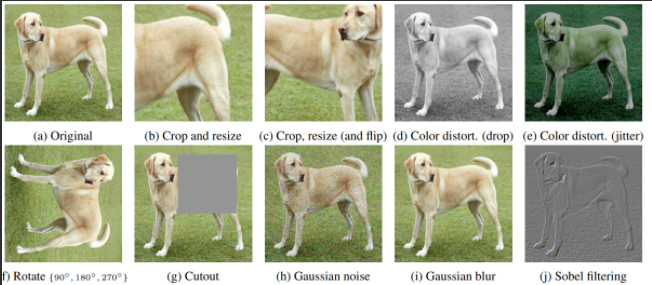
* İlk olarak, bir arttırma seçilir, örneğin, kesme (maskalama) olarak bilinen bir arttırma. Ardından, bu arttırma giriş verilerine, etiketli veya etiketlenmemiş olsun, otomatik olarak uygulanır.
* Bu şekilde, kedi ve köpek veritabanımız için yirmi milyon görüntü elde edilir: on milyon orijinal görüntü ve on milyon arttırılmış görüntü, köpek veya kedi olmalarına bakılmaksızın.
* Başka bir deyişle, on milyon çift orijinal ve karşılık gelen arttırılmış görüntü bulunmaktadır.
* Sinyal (zamansal kayıtlar-temporal records) alanında popüler bir dizi arttırma tekniği de bu şekilde gösterilmiştir:
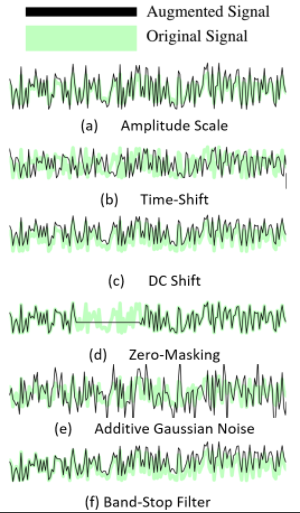

In [8]:
import tensorflow as tf
import matplotlib as mt

In [9]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255
print('x_train :  {}'.format(x_train.shape))

x_train :  (50000, 32, 32, 3)


In [10]:
# Veri arttırma işlemi için plot fonksiyonu tanımlayalım.
def plotting_function(original, augmented, general_title):
  titles = ['original', 'augmented']
  images = [original, augmented]
  fig, ax = mt.pyplot.subplots(1, 2, figsize = (4, 3))
  fig.suptitle(general_title.title())

  fig.tight_layout()
  mt.pyplot.subplots_adjust(wspace = 0.05, hspace = 0.05)

  for i in range(2):
    ax[i].imshow(images[i])
    ax[i].set_title(titles[i].title())
    ax[i].set_xticks([])
    ax[i].set_yticks([])
  
  mt.pyplot.show()

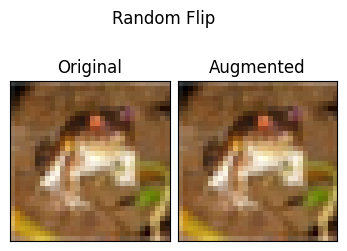

In [11]:
# Image augmentation - random flip
augmented_function = tf.keras.layers.RandomFlip(mode = 'horizontal_and_vertical')

original = x_train[0,:,:,:]
augmented = augmented_function(original)

plotting_function(original, augmented, 'Random Flip')

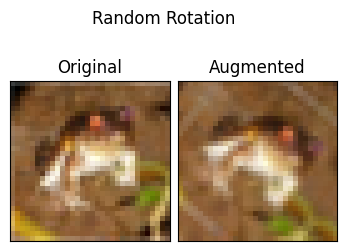

In [12]:
# Image augmentation - random rotation
augmented_function = tf.keras.layers.RandomRotation(factor = 0.2)
original = x_train[0,:,:,:]
augmented = augmented_function(original)
plotting_function(original, augmented, 'Random Rotation')

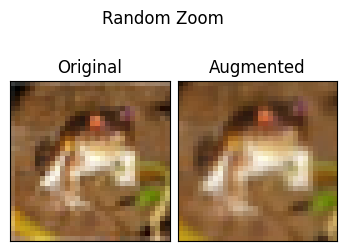

In [13]:
# Image augmentation - random zoom
augmented_function = tf.keras.layers.RandomZoom(height_factor=.25)
original = x_train[0,:,:,:]
augmented = augmented_function(original)
plotting_function(original, augmented, 'Random Zoom')

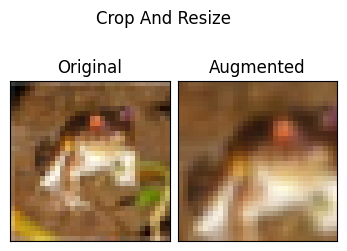

In [14]:
# Image augmentation - random crop and resize
augmented_function_01 = tf.keras.layers.RandomCrop(height=20, width=20)
augmented_function_02 = tf.keras.layers.Resizing(height=x_train.shape[1], width=x_train.shape[2])
augmented_function = tf.keras.Sequential([augmented_function_01, augmented_function_02])
original = x_train[0,:,:,:]
augmented = augmented_function(original)
plotting_function(original, augmented, 'Crop and Resize')

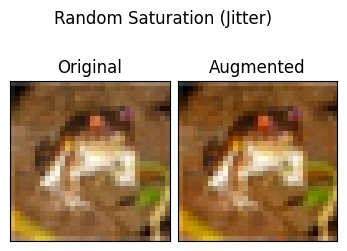

In [15]:
# Image augmentation - random saturation (jitter)
augmented_function     = lambda image: tf.cast(tf.image.random_saturation(image*255, lower = 1, upper = 5), dtype = tf.float32)/255
original  = x_train[0,:,:,:]

augmented = augmented_function(original)

plotting_function(original, augmented, 'Random Saturation (Jitter)')


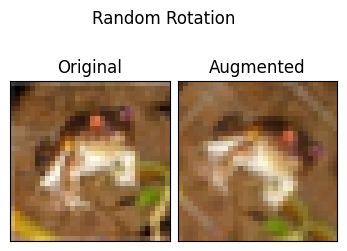

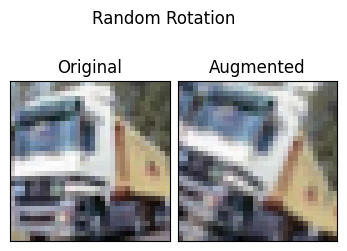

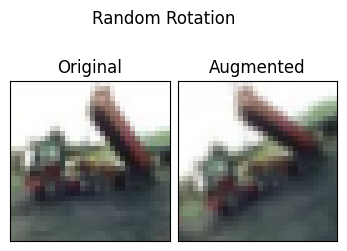

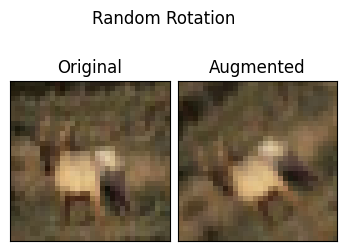

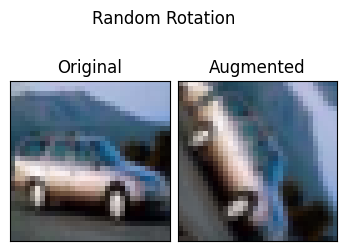

Orijinal eğitim girdilerinin boyutu: (50000, 32, 32, 3)
Artırılmış eğitim girdilerinin boyutu: (50000, 32, 32, 3)
pretext girdilerinin boyutu: (100000, 32, 32, 3)


In [16]:
# Contrastive training inputlarını oluşturalım.
# Random rotation gibi bir arttırma yöntemi seçelim.
augmented_function = tf.keras.layers.RandomRotation(factor = 0.2)

x_train_augmented = augmented_function(x_train)

# İlk beş artırılmış görüntüyü çizelim.
for i in range(5):
  # plotting_function(x_train[i,:,:,:], x_train_augmented[i,:,:,:], 'Random Flip')
  plotting_function(x_train[i,:,:,:], x_train_augmented[i,:,:,:], 'Random Rotation')
  # plotting_function(x_train[i,:,:,:], x_train_augmented[i,:,:,:], 'Random Zoom')
  # plotting_function(x_train[i,:,:,:], x_train_augmented[i,:,:,:], 'Crop and Resize')
  # plotting_function(x_train[i,:,:,:], x_train_augmented[i,:,:,:], 'Random Saturation (Jitter)')

# orijinal ve artırılmış eğitim verilerini pretext (prx) için birleştirelim.
x_train_pretext = tf.concat([x_train, x_train_augmented], axis = 0)

print("Orijinal eğitim girdilerinin boyutu: {}".format(x_train.shape))
print("Artırılmış eğitim girdilerinin boyutu: {}".format(x_train_augmented.shape))
print("pretext girdilerinin boyutu: {}".format(x_train_pretext.shape))

## Denetimli Karşılaştırmalı Öğrenme (Supervised Contrastive Learning)
* Supervised contrastive learning'de, bir arttırılmış görüntü sahte etiketleme (pseudo-labeled) ile pozitif olarak işaretlenir (sınıf 1) ve orijinal görüntü sahte etiketleme (pseudo-labeled) ile negatif olarak işaretlenir (sınıf 0).
* Pretext görevinin amacı, pretext modelinin bu sahte etiketleri tüm iki milyon görüntüyü kullanarak öğrenmesidir. Daha sonra, pretext modeli, downstream görevinde sınırlı sayıda etiketli veri kullanılarak aktarılır ve ince ayar yapılır.

## Denetimsiz Karşılaştırmalı Öğrenme (Unsupervised Contrastive Learning)
* Unsupervised contrastive learning'de, sahte etiketleme (pseudo labeling) gerekmemektedir.
* Pretext görevinin amacı, ön koşul modelinin yirmi milyon görüntünün özellik temsilleri arasındaki kontrastı öğrenmesidir.
* Özellik temsilleri (Feature representations) genellikle pretext modelinin son (veya neredeyse son) yoğun katmanlarından (dense layers) elde edilir.
* Örneğin, bir pretext modelinin kayıp fonksiyonu (cost function), eğitim kümesindeki bir orijinal görüntünün özellik temsillerini ve onun arttırılmış (augmented) versiyonunu bir araya getirmeyi hedeflerken, onları aynı kümedeki diğer veri noktalarının özellik temsillerinden ayırmayı amaçlar.
* İşte Chen ve arkadaşlarının 2020'deki unsupervised contrastive SSL (Self-Supervised Learning) çalışması olan simCLR:
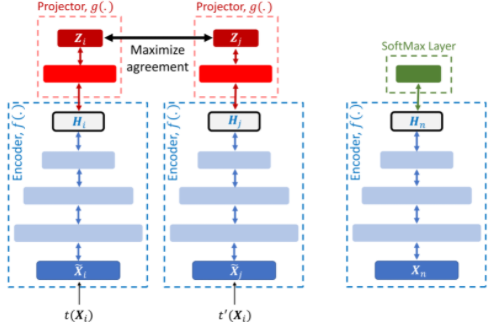

## Üretken Öğrenme (Generative Learning)
* Generative SSL'de, çoğu zaman bir arttırma olmadan unsupervised bir modelden pretext modeli elde edilir.
* Örneğin, pretext görevi, enerative adversarial network (GAN) kullanarak (örneğin, kediler ve köpeklerin görüntüleri gibi) sentetik giriş verisi üretmek ve bunları mevcut veri dağılımına yakın hale getirmektir.
* Sonra, GAN'ın ayrıştırıcısı (discriminator), downstream görevindeki sınırlı etiketli veriler kullanılarak aktarılır ve ince ayar yapılır.
* Başka bir yöntem, mevcut giriş dağılımını tam olarak yeniden oluşturan bir autoencoder bir kodlayıcı çıkarmak ve bunu downstream görevindeki sınırlı etiketli veriler kullanılarak aktararak ve ince ayar yaparak kullanmaktır.
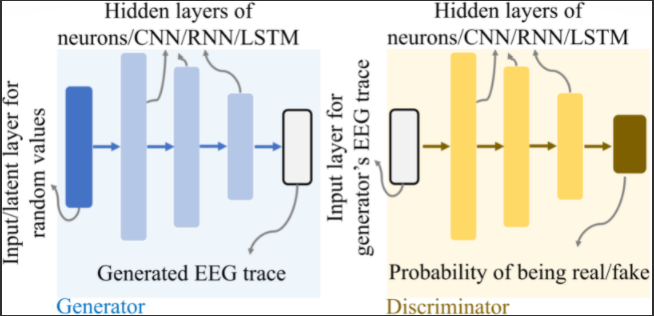


In [17]:
# Pseudo etiketleri oluşturalım.
y_train_pretext_positive = tf.ones((x_train.shape[0],1))
y_train_pretext_negative = tf.zeros((x_train_augmented.shape[0],1))

#based on the order of data points in datain_tr_prx
y_train_pretext = tf.concat([y_train_pretext_negative, y_train_pretext_positive], axis = 0)

#binary categorical for SoftMax:
y_train_pretext = tf.keras.utils.to_categorical(y_train_pretext)

print("Pretext eğitim çıktılarının boyutu: {}".format(y_train_pretext.shape))

Pretext eğitim çıktılarının boyutu: (100000, 2)


* Bu kısımda, CIFAR-10 veri kümesinde yalnızca 1000 eğitim görüntüsünün etiketlendiğini varsayıyoruz.
* Tüm eğitim verilerini kullanarak denetimli kontrastif pretext (prx) modeli geliştiriyoruz ve bunu downstream (dwm) görevindeki 1000 etiketli görüntü üzerinde ince ayar yapıyoruz.
* Ardından, ince ayar yapılmış modeli kullanarak test görüntülerini etiketliyoruz.
* Benzer bir veri dağılımına sahip eğitilmiş bir ağın olmadığını varsayıyoruz. Bu nedenle, modelimizin önceden eğitilmiş parametrelere sahip olmadığını (parametreleri rastgele oluşturmamız gerektiğini) kabul ediyoruz.
* Bu modeli, sadece 1000 etiketli veriyle eğitilen oldukça benzer tamamen denetimli (fully supervised) (fsp) bir modelin sonuçlarıyla karşılaştırıyoruz.
* Not: Burada üç model geliştirmemiz gerekiyor: model_fsp, model_prx ve model_dwm.

In [18]:
# Gerekli kütüphaneler
import tensorflow as tf
import copy

In [19]:
# HYPERPARAMETERS

# learning rates
lr_fsp       = 0.001
lr_prx       = 0.001
lr_dwm_trf   = 0.01
lr_dwm_fnt   = 0.0001

# batch sizes
batch_fsp      = 128
batch_prx      = 128
batch_dwm_trf  = 128
batch_dwm_fnt  = 128

# epochs
# Doğru bir karşılaştırma yapmak için epoch_dwm_trf + epoch_dwm_fnt = epoch_fsp koşulunu koruyoruz.
epoch_fsp      = 25
epoch_prx      = 10
epoch_dwm_trf  = 15
epoch_dwm_fnt  = 10

In [20]:
# Veriyi yükleme ve işleme
(data_x_tr, data_y_tr), (data_x_te, data_y_te) = tf.keras.datasets.cifar10.load_data()

# değerleri 0 ile 1 arasında dönüştür
data_x_tr = data_x_tr / 255
data_x_te = data_x_te / 255

data_y_tr = tf.keras.utils.to_categorical(data_y_tr)
data_y_te = tf.keras.utils.to_categorical(data_y_te)

# Boyutları yazdıralım.
print('data_x_tr: {}'.format(data_x_tr.shape))
print('data_x_te: {}'.format(data_x_te.shape))
print('data_y_tr: {}'.format(data_y_tr.shape))
print('data_y_te: {}'.format(data_y_te.shape))

data_x_tr: (50000, 32, 32, 3)
data_x_te: (10000, 32, 32, 3)
data_y_tr: (50000, 10)
data_y_te: (10000, 10)


In [21]:
# Contrastive eğitim girdi ve çıktılarını oluşturalım.

# Bir arttırma yöntemi seçelim; random rotation gibi...
fun_augment     = tf.keras.layers.RandomRotation(factor = 0.2)

data_x_tr_augmented = fun_augment(data_x_tr)

# pretext(prx) için arttırılmış ve orijinal veriyi birleştirelim:
data_x_tr_prx = tf.concat([data_x_tr,data_x_tr_augmented], axis = 0)

# contrastive çıktıları
data_y_tr_prx_positive = tf.ones((data_x_tr.shape[0],1))
data_y_tr_prx_negative = tf.zeros((data_x_tr_augmented.shape[0],1))

# Veri noktalarının data_x_tr_prx'deki sırasına dayalı olarak çıktı birleştirme
data_y_tr_prx = tf.concat([data_y_tr_prx_negative, data_y_tr_prx_positive], axis=0)

# SoftMax için ikili kategorik dönüşüm:
data_y_tr_prx = tf.keras.utils.to_categorical(data_y_tr_prx)

In [22]:
# Etiketli eğitim verisini sınırlayalım.

# Eğitim verilerinden num_labeled kadarını rastgele seçelim.
index_tr  = tf.experimental.numpy.random.randint(0, 
                                                 data_x_tr.shape[0], 
                                                 num_labeled)

data_x_tr_labeled = data_x_tr[index_tr,:,:,:]
data_y_tr_labeled = data_y_tr[index_tr,:]

# Okunabilirlik için...
data_x_tr_fsp = copy.deepcopy(data_x_tr_labeled)
data_y_tr_fsp = copy.deepcopy(data_y_tr_labeled)

data_x_tr_dwm = copy.deepcopy(data_x_tr_labeled)
data_y_tr_dwm = copy.deepcopy(data_y_tr_labeled)

# 50,000 eğitim girdimiz var; bunlardan num_labeled kadarı etiketlidir.

In [23]:
# model_fsp ve model_dwm'yi DenseNet121'ye benzer şekilde oluşturuyoruz.
layer_x = tf.keras.Input(shape=(data_x_tr.shape[1], 
                                data_x_tr.shape[2],
                                data_x_tr.shape[3]))


upscale = tf.keras.layers.Lambda(lambda x: tf.image.resize_with_pad(x,
                                                                    160,
                                                                    160,
                                                                    method=tf.image.ResizeMethod.BILINEAR))(layer_x)


model_DenseNet121 = tf.keras.applications.DenseNet121(include_top  = False,
                                                      weights      = None,
                                                      input_shape  = (160,160,3),
                                                      input_tensor = upscale,
                                                      pooling      = 'max')

# Tamamen denetimli modelimizin model_base'ini oluşturmak için model_DenseNet121'i klonluyoruz ve aynı zamanda pretext modeli için de aynısını yapıyoruz.
# Not: Pretext görevinden sonra downstream modelini pretext modelini kullanarak klonluyoruz.
model_base_fsp =  tf.keras.models.clone_model(model_DenseNet121)
model_base_prx =  tf.keras.models.clone_model(model_DenseNet121)

# model_base_fsp ve model_base_prx'in parametrelerini, model_DenseNet121'in rastgele oluşturulan parametreleriyle aynı şekilde ayarlıyoruz, böylece her iki modelin de öğrenme başlangıç noktasını aynı yaparak doğru bir karşılaştırma yapmış oluruz.
model_base_fsp.set_weights(model_DenseNet121.get_weights())
model_base_prx.set_weights(model_DenseNet121.get_weights())

# Şimdi model_fsp ve model_prx'in batch norm katmanlarını oluşturuyoruz.
layer_batchnorm_fsp = tf.keras.layers.BatchNormalization()
layer_batchnorm_prx = tf.keras.layers.BatchNormalization()

# Şimdi model_fsp ve model_prx'in çıkış katmanlarını oluşturuyoruz.
layerou_fsp = tf.keras.layers.Dense(data_y_tr_fsp.shape[-1], 
                                    activation = 'softmax')

layerou_prx = tf.keras.layers.Dense(data_y_tr_prx.shape[-1], 
                                    activation = 'softmax')

# Şimdi model_fsp ve model_prx'i oluşturuyoruz.
model_fsp   = tf.keras.models.Sequential([model_base_fsp, 
                                          layer_batchnorm_fsp, 
                                          layerou_fsp])

model_prx   = tf.keras.models.Sequential([model_base_prx, 
                                          layer_batchnorm_prx, 
                                          layerou_prx])

model_fsp.compile(optimizer = tf.keras.optimizers.Adam(lr_fsp), 
                  loss      = 'categorical_crossentropy', 
                  metrics   = ['accuracy'])

model_prx.compile(optimizer = tf.keras.optimizers.Adam(lr_prx), 
                  loss      = 'categorical_crossentropy', 
                  metrics   = ['accuracy'])

# model_fsp'nin model_prx ile benzer hiperparametrelere sahip olup olmadığını kontrol ediyoruz.
# Not: model_fsp ve model_prx'in son katmanlarının benzer olmasını beklemiyoruz, ancak daha sonra model_dwm'nin ilk parametrelerinin model_fsp ile aynı olduğundan emin olmamız gerekiyor.
print('Base model | fsp: ', model_fsp.layers[0].layers[10].weights[0][0][0][0][:5])
print('Base model | prx: ', model_prx.layers[0].layers[10].weights[0][0][0][0][:5])

print('Batch normalizaiton katmanı | fsp: ', model_fsp.layers[1].weights[:2])
print('Batch normalizaiton katmanı | prx: ', model_prx.layers[1].weights[:2])

# Son katmanın başlangıç parametrelerini (initial parameters) daha sonra kullanmak üzere model_fsp'yi saklıyoruz.
layerou_fsp_initial_parameters = copy.deepcopy(model_fsp.layers[2].weights)

Base model | fsp:  tf.Tensor([0.04923034 0.11591677 0.16923864 0.11842708 0.12461396], shape=(5,), dtype=float32)
Base model | prx:  tf.Tensor([0.04923034 0.11591677 0.16923864 0.11842708 0.12461396], shape=(5,), dtype=float32)
Batch normalizaiton katmanı | fsp:  [<tf.Variable 'batch_normalization_1/gamma:0' shape=(1024,) dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>, <tf.Variable 'batch_normalization_1/beta:0' shape=(1024,) dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>]
Batch normalizaiton katmanı | prx:  [<tf.Variable 'batch_normalization_2/gamma:0' shape=(1024,) dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>, <tf.Variable 'batch_normalization_2/beta:0' shape=(1024,) dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>]


In [24]:
# model_fsp'yi eğitelim.

# Burada herhangi bir doğrulama (validation split) eklemiyoruz çünkü aşırı öğrenmeyi (overfitting) sonradan test verileri kullanarak doğrulayabiliriz.
history_fsp = model_fsp.fit(data_x_tr_fsp, 
                            data_y_tr_fsp, 
                            epochs           = epoch_fsp, 
                            batch_size       = 64, 
                            verbose          = 1, 
                            shuffle          = True)

Epoch 1/25
40/40 [==============================] - 92s 436ms/step - loss: 2.1695 - accuracy: 0.2732
Epoch 2/25
40/40 [==============================] - 14s 358ms/step - loss: 1.7306 - accuracy: 0.4048
Epoch 3/25
40/40 [==============================] - 14s 355ms/step - loss: 1.5984 - accuracy: 0.4512
Epoch 4/25
40/40 [==============================] - 14s 353ms/step - loss: 1.5294 - accuracy: 0.4684
Epoch 5/25
40/40 [==============================] - 14s 354ms/step - loss: 1.5306 - accuracy: 0.4676
Epoch 6/25
40/40 [==============================] - 14s 356ms/step - loss: 1.3509 - accuracy: 0.5404
Epoch 7/25
40/40 [==============================] - 14s 356ms/step - loss: 1.2257 - accuracy: 0.5828
Epoch 8/25
40/40 [==============================] - 14s 358ms/step - loss: 1.2131 - accuracy: 0.5808
Epoch 9/25
40/40 [==============================] - 14s 356ms/step - loss: 1.1708 - accuracy: 0.6048
Epoch 10/25
40/40 [==============================] - 14s 355ms/step - loss: 1.0122 - accura

In [25]:
# prx modelini eğitelim.

# Dikkat edelim test pretext verilerimiz olmadığı için aşırı öğrenmeyi izlemek için validation split ekliyoruz. Ayrıca, pretext eğitimi zaman alacağından "callbacks" kullanarak bazı erken durdurma kriterleri belirliyoruz.
callback = tf.keras.callbacks.EarlyStopping(monitor              = 'val_loss',
                                            patience             = 2,
                                            restore_best_weights = True)

history_prx = model_prx.fit(data_x_tr_prx, 
                            data_y_tr_prx, 
                            epochs           = 5, 
                            batch_size       = 16, 
                            verbose          = 1, 
                            shuffle          = True,
                            validation_split = 0.05,
                            callbacks        = [callback])

Epoch 1/5
5938/5938 [==============================] - 755s 116ms/step - loss: 0.5359 - accuracy: 0.7387 - val_loss: 0.2928 - val_accuracy: 0.8708
Epoch 2/5
5938/5938 [==============================] - 680s 115ms/step - loss: 0.3516 - accuracy: 0.8530 - val_loss: 0.2946 - val_accuracy: 0.8778
Epoch 3/5
5938/5938 [==============================] - 679s 114ms/step - loss: 0.2618 - accuracy: 0.8963 - val_loss: 0.2732 - val_accuracy: 0.8998
Epoch 4/5
5938/5938 [==============================] - 701s 118ms/step - loss: 0.2047 - accuracy: 0.9224 - val_loss: 0.2457 - val_accuracy: 0.9128
Epoch 5/5
5938/5938 [==============================] - 740s 125ms/step - loss: 0.1520 - accuracy: 0.9458 - val_loss: 0.2136 - val_accuracy: 0.9336


In [26]:
# model_fsp ve model_prx'nin benzer hiper-parametrelere sahip olup olmadığını kontrol edelim.
print('Base model | fsp: ', model_fsp.layers[0].layers[10].weights[0][0][0][0][:5])
print('Base model | prx: ', model_prx.layers[0].layers[10].weights[0][0][0][0][:5])

print('Batch normalizaiton katmanı | fsp: ', model_fsp.layers[1].weights[:2])
print('Batch normalizaiton katmanı | prx: ', model_prx.layers[1].weights[:2])

Base model | fsp:  tf.Tensor([0.0561286  0.11408247 0.17720279 0.10795929 0.12879257], shape=(5,), dtype=float32)
Base model | prx:  tf.Tensor([0.21119855 0.25242904 0.18141893 0.14559685 0.21475786], shape=(5,), dtype=float32)
Batch normalizaiton katmanı | fsp:  [<tf.Variable 'batch_normalization_1/gamma:0' shape=(1024,) dtype=float32, numpy=
array([1.0751176, 0.9879498, 1.0068449, ..., 1.0166657, 0.9710987,
       1.0571802], dtype=float32)>, <tf.Variable 'batch_normalization_1/beta:0' shape=(1024,) dtype=float32, numpy=
array([-0.01729259, -0.05045556, -0.01126219, ...,  0.04779835,
        0.02024676,  0.00719253], dtype=float32)>]
Batch normalizaiton katmanı | prx:  [<tf.Variable 'batch_normalization_2/gamma:0' shape=(1024,) dtype=float32, numpy=
array([-0.00410354,  0.00068402,  0.00607339, ...,  0.0129507 ,
       -0.01845846, -0.0193569 ], dtype=float32)>, <tf.Variable 'batch_normalization_2/beta:0' shape=(1024,) dtype=float32, numpy=
array([-0.00212322, -0.00051701,  0.0021333

In [28]:
# model_dwm'i yalnızca transfer öğrenme kullanarak oluşturalım ve eğitelim

# Downstream çıktı katmanı
layerou_dwm = tf.keras.layers.Dense(data_y_tr_dwm.shape[-1], 
                                    activation = 'softmax')

# Şimdi model_dwm'yi model_base_prx (eğitilmişle), layer_batchnorm_prx (eğitilmişle) ve layerou_dwm'i kullanarak oluşturuyoruz, ancak doğru bir fsp ve dwm karşılaştırması için dwm parametrelerini layerou_fsp_initial_parameters ile benzer hale getiriyoruz.

# Not: Transfer öğrenme seviyesinde model_base_prx ve layer_batchnorm_prx parametrelerini güncellemez ve yalnızca layerou_dwm öğrenmeye odaklanırız.
model_base_prx.trainable      = False
layer_batchnorm_prx.trainable = False

model_dwm   = tf.keras.models.Sequential([model_base_prx, 
                                          layer_batchnorm_prx, 
                                          layerou_dwm])


model_dwm.layers[2].set_weights(layerou_fsp_initial_parameters)


model_dwm.compile(optimizer = tf.keras.optimizers.Adam(lr_dwm_trf), 
                  loss      = 'categorical_crossentropy', 
                  metrics   = ['accuracy'])

model_dwm.summary()

history_dwm = model_dwm.fit(data_x_tr_dwm, 
                            data_y_tr_dwm, 
                            epochs           = epoch_dwm_trf, 
                            batch_size       = batch_dwm_trf, 
                            verbose          = 1, 
                            shuffle          = True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 batch_normalization_2 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 10)                10250     
                                                                 
Total params: 7,051,850
Trainable params: 10,250
Non-trainable params: 7,041,600
_________________________________________________________________
Epoch 1/15
20/20 [==============================] - 15s 306ms/step - loss: 2.0287 - accuracy: 0.2620
Epoch 2/15
20/20 [==============================] - 4s 189ms/step - loss: 1.7663 - accuracy: 0.3632
Epoch 3/15
20/20 [==================

In [29]:
# model_dwm'i ince ayar yapalım.
model_base_prx.trainable      = True
layer_batchnorm_prx.trainable = True

# Belirli bir model_base_prx katmanından sonra ince ayar yapabiliriz!
# fine_tune_after = 349
# for layer in model_base_prx.layers[:fine_tune_after]:
#   layer.trainable = False

model_dwm.compile(optimizer = tf.keras.optimizers.Adam(lr_dwm_fnt), 
                  loss      = 'categorical_crossentropy', 
                  metrics   = ['accuracy'])

model_dwm.summary()

history_dwm = model_dwm.fit(data_x_tr_dwm, 
                            data_y_tr_dwm, 
                            epochs           = epoch_dwm_fnt, 
                            batch_size       = batch_dwm_fnt, 
                            verbose          = 1, 
                            shuffle          = True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 batch_normalization_2 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 10)                10250     
                                                                 
Total params: 7,051,850
Trainable params: 6,966,154
Non-trainable params: 85,696
_________________________________________________________________
Epoch 1/10
20/20 [==============================] - 92s 974ms/step - loss: 2.2934 - accuracy: 0.3840
Epoch 2/10
20/20 [==============================] - 14s 715ms/step - loss: 2.0361 - accuracy: 0.4136
Epoch 3/10
20/20 [=================

In [30]:
# model_fsp ve model_dwm test doğruluklarını hesaplayalım...
acc_te_fsp = model_fsp.evaluate(data_x_te, 
                                   data_y_te, 
                                   batch_size = 128)

acc_te_dwm = model_dwm.evaluate(data_x_te, 
                                   data_y_te, 
                                   batch_size = 128)

print('fsp nin doğruluğu: {:05.2f}%'.format(acc_te_fsp[1]*100))
print('dwm nin doğruluğu: {:05.2f}%'.format(acc_te_dwm[1]*100))

79/79 [==============================] - 17s 187ms/step - loss: 1.7984 - accuracy: 0.3893
fsp nin doğruluğu: 37.03%
dwm nin doğruluğu: 38.93%


In [31]:
# Hafızayı temizleme
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.


In [3]:
import tensorflow as tf
import copy

In [4]:
# Hyper-parameters
num_labeled  = 1000

# learning rates
lr_fsp_trf   = 0.01
lr_fsp_fnt   = 0.0001

lr_prx_trf   = 0.01
lr_prx_fnt   = 0.00001

lr_dwm_trf   = 0.01
lr_dwm_fnt   = 0.0001


# batch sizes
batch_fsp_trf  = 128
batch_fsp_fnt  = 128

batch_prx_trf  = 128
batch_prx_fnt  = 128

batch_dwm_trf  = 128
batch_dwm_fnt  = 128


# epochs
epoch_fsp_trf  = 15
epoch_fsp_fnt  = 10 

epoch_prx_trf  = 15
epoch_prx_fnt  = 10

epoch_dwm_trf  = 15
epoch_dwm_fnt  = 10

In [5]:
# Veriyi yükleme ve işleme
(data_x_tr, data_y_tr), (data_x_te, data_y_te) = tf.keras.datasets.cifar10.load_data()

# değerleri 0 ile 1 arasında dönüştür
data_x_tr = data_x_tr / 255
data_x_te = data_x_te / 255

data_y_tr = tf.keras.utils.to_categorical(data_y_tr)
data_y_te = tf.keras.utils.to_categorical(data_y_te)

# Boyutları yazdıralım.
print('data_x_tr: {}'.format(data_x_tr.shape))
print('data_x_te: {}'.format(data_x_te.shape))
print('data_y_tr: {}'.format(data_y_tr.shape))
print('data_y_te: {}'.format(data_y_te.shape))

data_x_tr: (50000, 32, 32, 3)
data_x_te: (10000, 32, 32, 3)
data_y_tr: (50000, 10)
data_y_te: (10000, 10)


In [6]:
# Contrastive eğitim girdi ve çıktılarını oluşturalım.

# Bir arttırma yöntemi seçelim; random rotation gibi...
fun_augment     = tf.keras.layers.RandomRotation(factor = 0.2)

data_x_tr_augmented = fun_augment(data_x_tr)

# pretext(prx) için arttırılmış ve orijinal veriyi birleştirelim:
data_x_tr_prx = tf.concat([data_x_tr,data_x_tr_augmented], axis = 0)

# contrastive çıktıları
data_y_tr_prx_positive = tf.ones((data_x_tr.shape[0],1))
data_y_tr_prx_negative = tf.zeros((data_x_tr_augmented.shape[0],1))

# Veri noktalarının data_x_tr_prx'deki sırasına dayalı olarak çıktı birleştirme
data_y_tr_prx = tf.concat([data_y_tr_prx_negative, data_y_tr_prx_positive], axis=0)

# SoftMax için ikili kategorik dönüşüm:
data_y_tr_prx = tf.keras.utils.to_categorical(data_y_tr_prx)

In [9]:
# Etiketli eğitim verisini sınırlayalım.

# Eğitim verilerinden num_labeled kadarını rastgele seçelim.
index_tr  = tf.experimental.numpy.random.randint(0, 
                                                 data_x_tr.shape[0], 
                                                 num_labeled)

data_x_tr_labeled = data_x_tr[index_tr,:,:,:]
data_y_tr_labeled = data_y_tr[index_tr,:]

# Okunabilirlik için...
data_x_tr_fsp = copy.deepcopy(data_x_tr_labeled)
data_y_tr_fsp = copy.deepcopy(data_y_tr_labeled)

data_x_tr_dwm = copy.deepcopy(data_x_tr_labeled)
data_y_tr_dwm = copy.deepcopy(data_y_tr_labeled)

# 50,000 eğitim girdimiz var; bunlardan num_labeled kadarı etiketlidir.

In [8]:
# model_fsp ve model_dwm'yi DenseNet121'ye benzer şekilde oluşturuyoruz.
layer_x = tf.keras.Input(shape=(data_x_tr.shape[1], 
                                data_x_tr.shape[2],
                                data_x_tr.shape[3]))


upscale = tf.keras.layers.Lambda(lambda x: tf.image.resize_with_pad(x,
                                                                    160,
                                                                    160,
                                                                    method=tf.image.ResizeMethod.BILINEAR))(layer_x)


model_DenseNet121 = tf.keras.applications.DenseNet121(include_top  = False,
                                                      weights      = None,
                                                      input_shape  = (160,160,3),
                                                      input_tensor = upscale,
                                                      pooling      = 'max')

# Tamamen denetimli modelimizin model_base'ini oluşturmak için model_DenseNet121'i klonluyoruz ve aynı zamanda pretext modeli için de aynısını yapıyoruz.
# Not: Pretext görevinden sonra downstream modelini pretext modelini kullanarak klonluyoruz.
model_base_fsp =  tf.keras.models.clone_model(model_DenseNet121)
model_base_prx =  tf.keras.models.clone_model(model_DenseNet121)

# model_base_fsp ve model_base_prx'in parametrelerini, model_DenseNet121'in rastgele oluşturulan parametreleriyle aynı şekilde ayarlıyoruz, böylece her iki modelin de öğrenme başlangıç noktasını aynı yaparak doğru bir karşılaştırma yapmış oluruz.
model_base_fsp.set_weights(model_DenseNet121.get_weights())
model_base_prx.set_weights(model_DenseNet121.get_weights())

# Şimdi model_fsp ve model_prx'in batch norm katmanlarını oluşturuyoruz.
layer_batchnorm_fsp = tf.keras.layers.BatchNormalization()
layer_batchnorm_prx = tf.keras.layers.BatchNormalization()

# Şimdi model_fsp ve model_prx'in çıkış katmanlarını oluşturuyoruz.
layerou_fsp = tf.keras.layers.Dense(data_y_tr_fsp.shape[-1], 
                                    activation = 'softmax')

layerou_prx = tf.keras.layers.Dense(data_y_tr_prx.shape[-1], 
                                    activation = 'softmax')

# Şimdi model_fsp ve model_prx'i oluşturuyoruz.
model_fsp   = tf.keras.models.Sequential([model_base_fsp, 
                                          layer_batchnorm_fsp, 
                                          layerou_fsp])

model_prx   = tf.keras.models.Sequential([model_base_prx, 
                                          layer_batchnorm_prx, 
                                          layerou_prx])


In [9]:
# Transfer öğrenme ve fine-tuning kullanarak model_fsp'yi eğitmek

# Burada validation split eklemiyoruz çünkü overfitting durumunu daha sonra test verileri kullanarak kontrol edebiliriz.

# transfer learning
model_base_fsp.trainable      = False
layer_batchnorm_fsp.trainable = False

model_fsp.compile(optimizer = tf.keras.optimizers.Adam(lr_fsp_trf), 
                  loss      = 'categorical_crossentropy', 
                  metrics   = ['accuracy'])

# Fsp modelinin çıkış katmanının parametrelerini dwm modeli için saklıyoruz.

layerou_fsp_initial_parameters = copy.deepcopy(model_fsp.layers[2].weights)

model_fsp.summary()

history_fsp_trf = model_fsp.fit(data_x_tr_fsp, 
                                data_y_tr_fsp, 
                                epochs           = epoch_fsp_trf, 
                                batch_size       = batch_fsp_trf, 
                                verbose          = 1, 
                                shuffle          = True)

# fine-tuning
model_base_fsp.trainable      = True
layer_batchnorm_fsp.trainable = True

model_fsp.compile(optimizer = tf.keras.optimizers.Adam(lr_fsp_fnt), 
                  loss      = 'categorical_crossentropy', 
                  metrics   = ['accuracy'])


model_fsp.summary()

history_fsp_fnt = model_fsp.fit(data_x_tr_fsp, 
                                data_y_tr_fsp, 
                                epochs           = epoch_fsp_fnt, 
                                batch_size       = batch_fsp_fnt, 
                                verbose          = 1, 
                                shuffle          = True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 10)                10250     
                                                                 
Total params: 7,051,850
Trainable params: 10,250
Non-trainable params: 7,041,600
_________________________________________________________________
Epoch 1/15
8/8 [==============================] - 26s 970ms/step - loss: 2.3200 - accuracy: 0.1010
Epoch 2/15
8/8 [==============================] - 1s 178ms/step - loss: 2.3139 - accuracy: 0.1060
Epoch 3/15
8/8 [==========================

In [10]:
# Transfer öğrenme ve fine-tuning kullanarak prx modelini oluşturup eğitelim.

# Downstream çıktı katmanı
layerou_dwm = tf.keras.layers.Dense(data_y_tr_dwm.shape[-1], 
                                    activation = 'softmax')

# Şimdi model_dwm'yi model_base_prx (eğitilmiş), layer_batchnorm_prx (eğitilmiş) ve layerou_dwm kullanarak oluşturuyoruz, ancak doğru bir fsp ve dwm karşılaştırması için dwm parametrelerini layerou_fsp_initial_parameters'a benzer şekilde ayarlıyoruz.

# Not: Transfer öğrenme seviyesinde model_base_prx ve layer_batchnorm_prx parametrelerini güncellemez, yalnızca layerou_dwm'yi öğrenmeye odaklanırız.
# Transfer learning
model_base_prx.trainable      = False
layer_batchnorm_prx.trainable = False

model_dwm   = tf.keras.models.Sequential([model_base_prx, 
                                          layer_batchnorm_prx, 
                                          layerou_dwm])

model_dwm.layers[2].set_weights(layerou_fsp_initial_parameters)

model_dwm.compile(optimizer = tf.keras.optimizers.Adam(lr_dwm_trf), 
                  loss      = 'categorical_crossentropy', 
                  metrics   = ['accuracy'])

model_dwm.summary()

history_dwm = model_dwm.fit(data_x_tr_dwm, 
                            data_y_tr_dwm, 
                            epochs           = epoch_dwm_trf, 
                            batch_size       = batch_dwm_trf, 
                            verbose          = 1, 
                            shuffle          = True)

# Fine-tuning
model_base_prx.trainable      = True
layer_batchnorm_prx.trainable = True

# Belirli bir model_base_prx katmanından sonra fine-tuning yapabiliriz!
# fine_tune_after = 430
# for layer in model_base_prx.layers[:fine_tune_after]:
#   layer.trainable = False

model_dwm.compile(optimizer = tf.keras.optimizers.Adam(lr_dwm_fnt), 
                  loss      = 'categorical_crossentropy', 
                  metrics   = ['accuracy'])

model_dwm.summary()

history_dwm = model_dwm.fit(data_x_tr_dwm, 
                            data_y_tr_dwm, 
                            epochs           = epoch_dwm_fnt, 
                            batch_size       = batch_dwm_fnt, 
                            verbose          = 1, 
                            shuffle          = True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 10)                10250     
                                                                 
Total params: 7,051,850
Trainable params: 10,250
Non-trainable params: 7,041,600
_________________________________________________________________
Epoch 1/15
8/8 [==============================] - 8s 176ms/step - loss: 2.3214 - accuracy: 0.0980
Epoch 2/15
8/8 [==============================] - 1s 177ms/step - loss: 2.3072 - accuracy: 0.1140
Epoch 3/15
8/8 [=========================

In [11]:
# model_fsp ve model_dwm test doğruluklarını hesaplayalım...
acc_te_fsp = model_fsp.evaluate(data_x_te, 
                                   data_y_te, 
                                   batch_size = 128)

acc_te_dwm = model_dwm.evaluate(data_x_te, 
                                   data_y_te, 
                                   batch_size = 128)

print('fsp nin doğruluğu: {:05.2f}%'.format(acc_te_fsp[1]*100))
print('dwm nin doğruluğu: {:05.2f}%'.format(acc_te_dwm[1]*100))

79/79 [==============================] - 16s 179ms/step - loss: 34.7911 - accuracy: 0.1000
fsp nin doğruluğu: 10.00%
dwm nin doğruluğu: 10.00%


In [13]:
# Hafızayı temizleme
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Pretext SimCLR

* Chen et al. (2020), görüntü temsili için kontrastif öğrenmenin bir makine öğrenmesi çerçevesi modeli olan SimCLR'i önerdi.
* Bu unsupervised kontrastif model, fine-tuning yapıldıktan sonra CIFAR10, CIFAR100 ve Caltech-101 gibi çeşitli standart görüntü veri setleri üzerinde dikkate değer bir doğruluk artışı göstermiştir.
* SimCLR modeli, multi-layer encoderdan (regresör olarak da adlandırılır) ve genellikle sığ bir sinir ağından (yani dense layerlar) oluşur.
* Kodlayıcı (encoder) daha sonra downstream görevi için aktarılır.
* SimCLR modeli, pretext modelleri, bir yığında diğer veri noktalarının artırma temsillerinden temsil karşılıklılığını maksimize ederek ve temsilleri marjinalleştirerek zenginleştirir.
* Bu fikir, görüntü verileriyle sınırlı değildir ve temporal kayıtlar gibi veri türlerine de uygulanabilir.
* Aşağıdaki Şekil, Chen et al. (2020) SimCLR pretext modelini ve downstream sınıflandırma modelini göstermektedir.

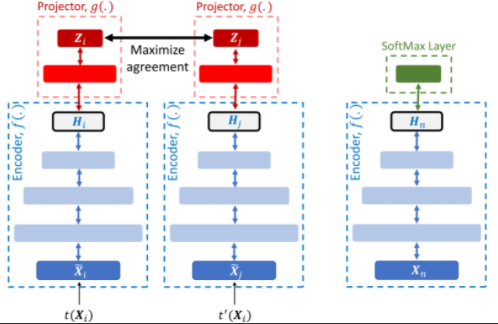

* SimCLR'ın üstünlüğü, encoderın (Şekildeki son kodlayıcının gizli katmanı (hidden layer)) daha zenginleştirilmiş özellik temsillerini elde etmek için bir yerine iki artırma kullanması ve pretext görev için kodlayıcının temsilinin derin bir dönüşümünü elde etmek için basit bir projeksiyon kullanmasıdır.

* Eğitim batchinde, belirli bir veri noktası için SimCLR'ın kayıp fonksiyonu artırma temsillerinin yakınlığını artırırken, bu temsilleri diğer veri noktalarının artırma temsillerinden marjinalleştirir.

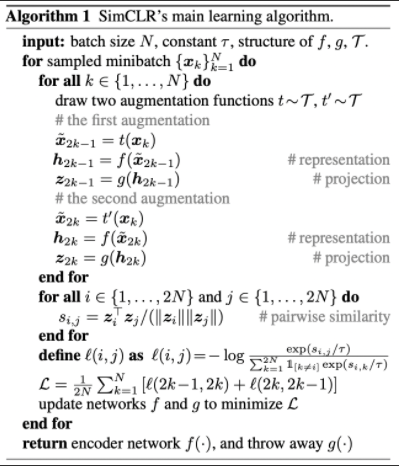

## SimCLR Loss ve Training Fonksiyonları
* İlk olarak, özel bir kayıp fonksiyonu oluşturuyoruz.
* Ardından, bir SimCLR eğitim fonksiyonu oluşturuyoruz.

### Kayıp (Loss) Fonksiyonu
* TensorFlow'da özel kayıp fonksiyonları, gerçek ve tahmini çıktı değerlerini gerektirir.

* SimCLR bir gözetimsiz model olduğu için, tahmin edilen çıktı değerleriyle aynı şekle sahip bazı sahte gerçek çıktı değerleri oluşturuyoruz.

* Tahmini çıktı değerleri, projeksiyonun temsili olarak z_estimate olarak gösterilir.

* N batch boyutu olduğunda, z_real matrisinin boyutu 2*N'dir.

* Amacımız, kayıp fonksiyonunda "for döngüleri"nden kaçınmak ve eğitim hızında çoklu iş parçacığı ve bellekten faydalanmaktır.

* Özel kayıp fonksiyonları, TensorFlow kütüphanesini kullanarak tensör formatında yazılmalıdır.

In [1]:
#Kütüphaneler
!pip install tensorflow==2.8.2

import tensorflow as tf
import copy
import warnings

from IPython.display import clear_output 

warnings.filterwarnings('ignore')

clear_output()

In [2]:
# Hyper-parameters
num_labeled  = 1000

# learning rates
lr_fsp_trf   = 0.01
lr_fsp_fnt   = 0.0001

lr_prx_trf   = 0.01
lr_prx_fnt   = 0.000001

lr_dwm_trf   = 0.01
lr_dwm_fnt   = 0.0001


# batch sizes
batch_fsp_trf  = 128
batch_fsp_fnt  = 128

batch_prx_trf  = 64
batch_prx_fnt  = 64

batch_dwm_trf  = 128
batch_dwm_fnt  = 128


# epochs
epoch_fsp_trf  = 15
epoch_fsp_fnt  = 10 

epoch_prx_trf  = 15
epoch_prx_fnt  = 10

epoch_dwm_trf  = 15
epoch_dwm_fnt  = 10

In [3]:
# Veriyi yükleme ve işleme
(data_x_tr, data_y_tr), (data_x_te, data_y_te) = tf.keras.datasets.cifar10.load_data()

# değerleri 0 ile 1 arasında dönüştür
data_x_tr = data_x_tr / 255
data_x_te = data_x_te / 255

data_y_tr = tf.keras.utils.to_categorical(data_y_tr)
data_y_te = tf.keras.utils.to_categorical(data_y_te)

# Boyutları yazdıralım.
print('data_x_tr: {}'.format(data_x_tr.shape))
print('data_x_te: {}'.format(data_x_te.shape))
print('data_y_tr: {}'.format(data_y_tr.shape))

data_x_tr: (50000, 32, 32, 3)
data_x_te: (10000, 32, 32, 3)
data_y_tr: (50000, 10)


In [4]:
# İki artırma fonksiyonu seçelim

# Crop and Resize
fun_augment_a  = tf.keras.layers.RandomCrop(height = 20, width = 20)
fun_augment_b  = tf.keras.layers.Resizing(height = data_x_tr.shape[1], 
                                          width = data_x_tr.shape[2])

fun_augment_01 = tf.keras.Sequential([fun_augment_a, fun_augment_b])

# Random rotation
fun_augment_02     = tf.keras.layers.RandomRotation(factor = 0.2)

In [5]:
# Etiketli eğitim verisini sınırlayalım.

# Eğitim verilerinden num_labeled kadarını rastgele seçelim.
index_tr = tf.experimental.numpy.random.randint(0, 
                                                data_x_tr.shape[0], 
                                                num_labeled)

data_x_tr_labeled = data_x_tr[index_tr,:,:,:]
data_y_tr_labeled = data_y_tr[index_tr,:]

data_x_tr_fsp = copy.deepcopy(data_x_tr)
data_x_tr_fsp = copy.deepcopy(data_x_tr_labeled)

data_x_tr_prx = copy.deepcopy(data_x_tr)

data_x_tr_dwm = copy.deepcopy(data_x_tr_labeled)
data_x_tr_dwm = copy.deepcopy(data_x_tr_labeled)

# 50,000 eğitim girdimiz var; bunlardan num_labeled kadarı etiketlidir.

In [6]:
# Custom loss function
@tf.function
def fun_simclr_loss(z_real, z_estimate):
  # z_real burada sadece bir dummy değişken
  del z_real

  # Belirli bir problem için optimize edilecek bir hiperparametre olan Temperature  parametresi
  toe = .1 

  num = int(z_estimate.shape[0]) #num = 2N

  # i ve j indeksleri
  ind0 = tf.repeat(tf.expand_dims(tf.range(0,num),axis = 0),num, axis = 0)
  ind1 = tf.reshape(ind0, (num**2,1))[:,0]
  ind2 = tf.reshape(tf.transpose(ind0), (num**2,1))[:,0]

  del ind0

  # z_estimate değerlerini ind1'e göre düzenleyelim
  vector_1 = tf.gather(z_estimate, ind1, axis = 0)
  del ind1

  # z_estimate değerlerini ind2'ye göre düzenleyelim
  vector_2 = tf.gather(z_estimate, ind2, axis = 0)
  del ind2

  # vector_1 ve vector_2'nin kosinüs benzerliğini hesaplayalım
  s = - tf.reshape(tf.keras.losses.cosine_similarity(vector_1, vector_2, axis=1),(num,num))

  del vector_1 
  del vector_2

  # l(i,j)'nin payını hesaplayalım
  nom = tf.exp(s/toe)

  # l(i,j)'nin paydasını hesaplayalım
  x1 = tf.exp(s/toe)

  del s

  x2 = 1-tf.eye(num, dtype = tf.float32)

  
  denom = tf.repeat(tf.expand_dims(tf.math.reduce_sum(x1 * x2, axis = 1), axis = 1), num, axis = 1)
  
  del x1
  del x2

  # Tüm i ve j için l(i,j)'yi hesaplayalım
  l = -tf.math.log(nom/denom)

  del nom
  del denom 

  # L'yi hesaplayalım
  ind_2k0 = tf.range(0,num,2, dtype=tf.int32) 
  ind_2k1 = tf.range(1,num,2, dtype=tf.int32)

  loss_mat1_1 = tf.gather(l, ind_2k0, axis = 0)
  loss_mat1_2 = tf.gather(loss_mat1_1, ind_2k1, axis = 1)
  loss_mat1   = tf.linalg.diag_part(loss_mat1_2)

  loss_mat2_1 = tf.gather(l,           ind_2k1, axis = 0)
  loss_mat2_2 = tf.gather(loss_mat2_1, ind_2k0, axis = 1)
  loss_mat2   = tf.linalg.diag_part(loss_mat2_2)

  del l

  loss_mat = loss_mat1 + loss_mat2

  L = tf.math.reduce_sum(loss_mat)/num

  return L

In [7]:
# SimCLR training function
def fun_train_simclr(model, datain, fun_augment_01, fun_augment_02, 
                     epochs = 100, batch_size = 32, verbose = 1, 
                     shuffle = True, patience = 3):
  
  num_data  = datain.shape[0]
  num_batch = int(num_data//batch_size)
  z_size    = model.layers[-1].weights[-1].shape[0]
  loss      = []  

  for i0 in range(epochs):
    counter    = 0
    loss_batch = []

    if shuffle:
      ind_shuffle = tf.experimental.numpy.random.randint(0,datain.shape[0],datain.shape[0])
      datain = datain[ind_shuffle,:]


    for i1 in range(num_batch):
      if i1 == num_batch - 1:
        ind_case = range(counter, num_data)
      else:
        ind_case = range(counter, counter + batch_size)


      x_tilda_01  = fun_augment_01(datain[ind_case,:])
      x_tilda_02  = fun_augment_02(datain[ind_case,:]) 

      x_tilda = tf.reshape(tf.concat([x_tilda_01,x_tilda_02], axis = 1), 
                               (x_tilda_01.shape[0] + x_tilda_02.shape[0],  
                                x_tilda_01.shape[1], x_tilda_01.shape[2], 
                                x_tilda_01.shape[3]))
      
      z_real = tf.random.uniform((x_tilda.shape[0],z_size)) # dummy variable

      # Train on batch
      var = model.train_on_batch((x_tilda, z_real));
      loss_batch.append(var[0]) 
      # Modeli derlerken loss_batch.append(var) olarak değiştirebilir ve herhangi bir 'metrics' dışında tutabiliriz.


      counter  = counter + batch_size 

      if verbose:
        if i1 == num_batch - 1:
          print("\r SimCLR | Epoch {:04d}/{:04d} - Batch {:04d}/{:04d} - Loss {:8.5F}".format(i0+1, epochs, i1+1, num_batch, sum(loss_batch)/len(loss_batch)), flush=True)
        else:
          print("\r SimCLR | Epoch {:04d}/{:04d} - Batch {:04d}/{:04d} - Loss {:8.5F}".format(i0+1, epochs, i1+1, num_batch, sum(loss_batch)/len(loss_batch)), end="", flush=True)

      

    loss.append(sum(loss_batch)/len(loss_batch))

    if i0>patience:
      loss_hist_min = min(loss)

      if loss[-1] > loss_hist_min:
        break
  
  return model, loss

In [10]:
# model_fsp ve model_dwm'yi DenseNet121'ye benzer şekilde oluşturuyoruz.
layer_x = tf.keras.Input(shape=(data_x_tr.shape[1], 
                                data_x_tr.shape[2],
                                data_x_tr.shape[3]))


upscale = tf.keras.layers.Lambda(lambda x: tf.image.resize_with_pad(x,
                                                                    160,
                                                                    160,
                                                                    method=tf.image.ResizeMethod.BILINEAR))(layer_x)


model_DenseNet121 = tf.keras.applications.DenseNet121(include_top  = False,
                                                      weights      ="imagenet",
                                                      input_shape  = (160,160,3),
                                                      input_tensor = upscale,
                                                      pooling      = 'max')

model_base_fsp =  tf.keras.models.clone_model(model_DenseNet121)
model_base_prx =  tf.keras.models.clone_model(model_DenseNet121) # encoder

model_base_fsp.set_weights(model_DenseNet121.get_weights())
model_base_prx.set_weights(model_DenseNet121.get_weights())

layer_batchnorm_fsp = tf.keras.layers.BatchNormalization()
layer_batchnorm_prx = tf.keras.layers.BatchNormalization()

# Şimdi SimCLR projector oluşturuyoruz.
layers_dense_prx = [tf.keras.Input(shape=(1024)),
                    tf.keras.layers.Dense(512, activation = 'relu'),
                    tf.keras.layers.Dense(128, activation = 'relu')]

model_projector = tf.keras.Sequential(layers_dense_prx)

# Şimdi model_fsp'nin output katmanlarını oluşturuyoruz.
layerou_fsp = tf.keras.layers.Dense(data_y_tr_fsp.shape[-1], activation = 'softmax')
#layerou_prx = tf.keras.layers.Dense(data_y_tr_prx.shape[-1], activation = 'softmax')

# Şimdi model_fsp ve model_prx'i oluşturuyoruz.
model_fsp   = tf.keras.models.Sequential([model_base_fsp, 
                                          layer_batchnorm_fsp, 
                                          layerou_fsp])

model_prx   = tf.keras.models.Sequential([model_base_prx, 
                                          layer_batchnorm_prx, 
                                          model_projector])

In [11]:
# Transfer öğrenme ve fine-tuning kullanarak model_fsp'yi eğitmek

# transfer learning
model_base_fsp.trainable      = False
layer_batchnorm_fsp.trainable = False

model_fsp.compile(optimizer = tf.keras.optimizers.Adam(lr_fsp_trf), 
                  loss      = 'categorical_crossentropy', 
                  metrics   = ['accuracy'])

layerou_fsp_initial_parameters = copy.deepcopy(model_fsp.layers[2].weights)

model_fsp.summary()

history_fsp_trf = model_fsp.fit(data_x_tr_fsp, 
                                data_y_tr_fsp, 
                                epochs           = epoch_fsp_trf, 
                                batch_size       = batch_fsp_trf, 
                                verbose          = 1, 
                                shuffle          = True)

# fine-tuning
model_base_fsp.trainable      = True
layer_batchnorm_fsp.trainable = True

model_fsp.compile(optimizer = tf.keras.optimizers.Adam(lr_fsp_fnt), 
                  loss      = 'categorical_crossentropy', 
                  metrics   = ['accuracy'])


model_fsp.summary()

history_fsp_fnt = model_fsp.fit(data_x_tr_fsp, 
                                data_y_tr_fsp, 
                                epochs           = epoch_fsp_fnt, 
                                batch_size       = batch_fsp_fnt, 
                                verbose          = 1, 
                                shuffle          = True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 batch_normalization_2 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 10)                10250     
                                                                 
Total params: 7,051,850
Trainable params: 10,250
Non-trainable params: 7,041,600
_________________________________________________________________
Epoch 1/15
8/8 [==============================] - 20s 562ms/step - loss: 9.2925 - accuracy: 0.1670
Epoch 2/15
8/8 [==============================] - 1s 180ms/step - loss: 3.8174 - accuracy: 0.4030
Epoch 3/15
8/8 [========================

In [12]:
# Transfer öğrenme ve fine-tuning kullanarak prx modelini eğitelim.

# Transfer learning
model_base_prx.trainable      = False
layer_batchnorm_prx.trainable = False

model_prx.compile(optimizer = tf.keras.optimizers.Adam(lr_prx_trf), 
                  loss      = fun_simclr_loss, 
                  metrics   = 'mean_squared_error')

model_prx.summary()

model_prx, _ = fun_train_simclr(model_prx, 
                                data_x_tr_prx, 
                                fun_augment_01, 
                                fun_augment_02, 
                                epochs     = epoch_prx_trf, 
                                batch_size = batch_prx_trf, 
                                verbose    = 1, 
                                patience   = 1)

# Fine-tuning
model_base_prx.trainable      = True
layer_batchnorm_prx.trainable = True


model_prx.compile(optimizer = tf.keras.optimizers.Adam(lr_prx_fnt), 
                  loss      = fun_simclr_loss, 
                  metrics   = 'mean_squared_error')

model_prx.summary()

model_prx, _ = fun_train_simclr(model_prx, 
                                data_x_tr_prx, 
                                fun_augment_01, 
                                fun_augment_02, 
                                epochs     = epoch_prx_fnt, 
                                batch_size = batch_prx_fnt, 
                                verbose    = 1, 
                                patience   = 1)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 batch_normalization_3 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 sequential_2 (Sequential)   (None, 128)               590464    
                                                                 
Total params: 7,632,064
Trainable params: 590,464
Non-trainable params: 7,041,600
_________________________________________________________________


ValueError: ignored

In [ ]:
# Transfer-öğrenme ve ince ayar kullanarak dwm modeli oluşturup ve eğitelim

layerou_dwm = tf.keras.layers.Dense(data_y_tr_dwm.shape[-1], 
                                    activation = 'softmax')

model_base_prx.trainable      = False
layer_batchnorm_prx.trainable = False

model_dwm   = tf.keras.models.Sequential([model_base_prx, 
                                          layer_batchnorm_prx, 
                                          layerou_dwm])

model_dwm.layers[2].set_weights(layerou_fsp_initial_parameters)

# Transfer learning
model_dwm.compile(optimizer = tf.keras.optimizers.Adam(lr_dwm_trf), 
                  loss      = 'categorical_crossentropy', 
                  metrics   = ['accuracy'])

model_dwm.summary()

history_dwm = model_dwm.fit(data_x_tr_dwm, 
                            data_y_tr_dwm, 
                            epochs           = epoch_dwm_trf, 
                            batch_size       = batch_dwm_trf, 
                            verbose          = 1, 
                            shuffle          = True)

#Fine-tuning
model_base_prx.trainable      = True
layer_batchnorm_prx.trainable = True

# We can fine-tune after certain model_base_prx layer!
# fine_tune_after = 430
# for layer in model_base_prx.layers[:fine_tune_after]:
#   layer.trainable = False

model_dwm.compile(optimizer = tf.keras.optimizers.Adam(lr_dwm_fnt), 
                  loss      = 'categorical_crossentropy', 
                  metrics   = ['accuracy'])

model_dwm.summary()

history_dwm = model_dwm.fit(data_x_tr_dwm, 
                            data_y_tr_dwm, 
                            epochs           = epoch_dwm_fnt, 
                            batch_size       = batch_dwm_fnt, 
                            verbose          = 1, 
                            shuffle          = True)


In [ ]:
# model_fsp ve model_dwm test doğruluklarını hesaplayalım
_, acc_te_fsp = model_fsp.evaluate(data_x_te, 
                                   data_y_te, 
                                   batch_size = 128)

_, acc_te_dwm = model_dwm.evaluate(data_x_te, 
                                   data_y_te, 
                                   batch_size = 128)

print('Accuracy of fsp: {:05.2f}%'.format(acc_te_fsp*100))
print('Accuracy of dwm: {:05.2f}%'.format(acc_te_dwm*100))

In [ ]:
%reset